In this document, we quantify the amount of cross-talk occuring between pixels in a CMOS image sensor. We believe that one cause of this cross-talk is diffusion of minority carriers (electrons): when a photon is absorbed, creating a photoelectron, close to the surface of a backside-illuminated sensor (outside of the depletion region), the electron may diffuse into nearby pixels.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
coeff_hdul = fits.open('/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Final Data Products/Calibration/Calibration Data/coeff_array_HSHGRS.fits')
coeff_array = coeff_hdul[0].data
# mean_bias_hdul = fits.open('/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Final Data Products/Calibration/Calibration Data/master_bias_CMS.fits')
# mean_bias_frame = mean_bias_hdul[0].data
# When taking this data, I already did bias subtraction
mean_bias_frame = np.zeros_like(coeff_array[0])
def correct_images(image_stack, coeffs, transition_value, high_cutoff, bits, order_low, bias_frame=None, verbose=False):
    corrected_stack = np.zeros_like(image_stack, dtype=np.uint16)
    order_high = len(coeffs) - order_low
    if bias_frame is not None:
        image_stack = image_stack - bias_frame
    for i, frame in enumerate(image_stack):
        corrected_frame = np.zeros_like(frame, dtype=float)
        low_vals_frame = np.zeros_like(frame)
        low_vals_frame[frame <= transition_value] = frame[frame <= transition_value]
        low_vals_true_frame = frame <= transition_value
        high_vals_frame = np.zeros_like(frame)
        high_vals_frame[(frame > transition_value) & (frame < high_cutoff)] = frame[(frame > transition_value) & (frame < high_cutoff)]
        high_vals_true_frame = (frame > transition_value) & (frame < high_cutoff)
        saturated_vals_true_frame = frame >= high_cutoff
        for j in range(order_low - 1):
            corrected_frame += coeffs[j] * low_vals_frame.astype(float) ** (order_low - 1 - j)
        for j in range(order_high - 1):
            corrected_frame += coeffs[j + order_low] * high_vals_frame.astype(float) ** (order_high - 1 - j)
            # For saturated values, set the corrected value to the correction of high_cutoff
            corrected_frame += coeffs[j + order_low] * (high_cutoff * saturated_vals_true_frame).astype(float) ** (order_high - 1 - j)
        # Add the correct constant term
        corrected_frame += coeffs[order_low - 1] * low_vals_true_frame
        corrected_frame += coeffs[-1] * high_vals_true_frame
        corrected_frame += coeffs[-1] * saturated_vals_true_frame
        # Bound corrected_frame between 0 and 2**bits - 1
        corrected_frame[corrected_frame < 0] = 0
        corrected_frame[corrected_frame > 2**bits - 1] = 2**bits - 1
        # Make NaNs equal to 2 ** bits - 1
        corrected_frame[np.isnan(corrected_frame)] = 2 ** bits - 1
        corrected_stack[i] = np.rint(corrected_frame).astype(np.uint16)
        if verbose:
            print(i, np.median(corrected_stack[i]))
    return corrected_stack

In [3]:
%matplotlib inline
data_folder = os.getcwd() + '/Intrapixel Response/IPRF Data/Spot Characterization/HS_HG_RS'
bits = 16
# data_folder = os.getcwd() + '/data/IPRF Data/Spot Characterization/IMX455'
wavelengths = np.array([400, 625, 875])
plot_img = np.zeros((11, 11))

for color in ['Blue', 'Red', 'NIR']:
    for level in ['faint', 'medium', 'bright']:
        central_pix_fracs = np.zeros(3)
        mean_saturation_level = 0
        for i, ind in enumerate(['1', '2', '3']):
            filename = data_folder + '/' + color + '/spot_image_' + level + '_' + ind + '.fits'
            test_data = fits.open(filename)
            # Get start pixel from header
            start_row = test_data[0].header['ROI START ROW']
            start_col = test_data[0].header['ROI START COL']
            coeff_array_roi = coeff_array[:, start_row:start_row + 31, start_col:start_col + 31]
            bias_frame_roi = mean_bias_frame[start_row:start_row + 31, start_col:start_col + 31]
            # Extract data from fits file
            roi_frame = test_data[0].data
            # roi_frame = correct_images(np.array([roi_frame]), coeff_array_roi, 3000, 60000, 16, 12, bias_frame_roi)[0]
            roi_frame = correct_images(np.array([roi_frame]), coeff_array_roi, 750, 15000, 14, 12, bias_frame_roi)[0]
            dark_val = np.mean(roi_frame[-2:])
            roi_frame = roi_frame[10:21, 10:21]
            central_pix_val = np.max(roi_frame)
            central_pix_frac = (central_pix_val - dark_val) / (np.sum(roi_frame) - dark_val * roi_frame.size)
            if color == 'Blue' and level =='bright':
                plot_img += (roi_frame - dark_val) / 3
            central_pix_fracs[i] = central_pix_frac
            mean_saturation_level += central_pix_val / 2 ** bits
            # print(level + ' ' + ind)
            # print('Central Pixel Value:', central_pix_val)
            # print('Central Pixel Fraction:', central_pix_frac)
            # print(np.sum(brightest - dark_val) / (np.sum(test_data) - dark_val * test_data.size))
            # print()
        mean_central_pix_frac = np.mean(central_pix_fracs)
        std_central_pix_frac = np.std(central_pix_fracs, ddof=1)
        mean_saturation_level /= 3
        print(level, color, 'mean fraction:', mean_central_pix_frac, 'pm ', std_central_pix_frac, '. Mean saturation level:', mean_saturation_level)


faint Blue mean fraction: 0.4611842447044616 pm  0.050561239128835256 . Mean saturation level: 0.017359415690104168
medium Blue mean fraction: 0.48030340324706317 pm  0.019106591198397672 . Mean saturation level: 0.084075927734375
bright Blue mean fraction: 0.4865171580503185 pm  0.006353768080305265 . Mean saturation level: 0.16600545247395834
faint Red mean fraction: 0.6251983939926782 pm  0.06531718555220371 . Mean saturation level: 0.025909423828125
medium Red mean fraction: 0.5668729935353237 pm  0.026008383909599177 . Mean saturation level: 0.12324015299479167
bright Red mean fraction: 0.5474567287862031 pm  0.0011572673825847694 . Mean saturation level: 0.236053466796875
faint NIR mean fraction: 0.4608910753359987 pm  0.08423196710488629 . Mean saturation level: 0.0147247314453125
medium NIR mean fraction: 0.4037781377621727 pm  0.004621404224122492 . Mean saturation level: 0.06864420572916667
bright NIR mean fraction: 0.4026563777156406 pm  0.010147288650481742 . Mean saturatio

In [4]:
plot_img = plot_img / np.sum(plot_img) * 100
# Just get the central 5x5 box
plot_img = plot_img[3:8, 3:8]
# Make any negative values zero
plot_img[plot_img < 0] = 0.0001

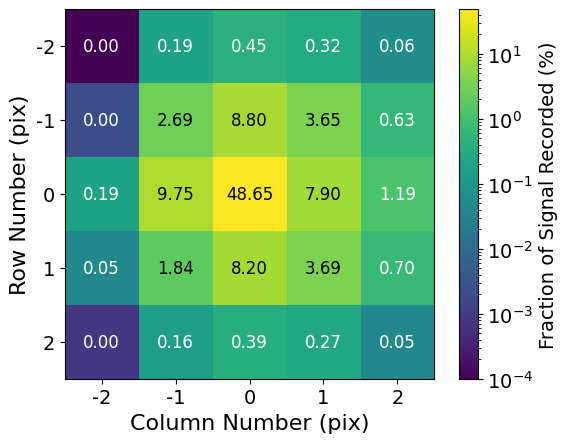

In [9]:
%matplotlib inline
# Make a heat map with the couplingelation array. Put the associated value on each square.
# Increase overall fontsize
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
cax = ax.imshow(plot_img,norm='log' )
fig.colorbar(cax, label='Fraction of Signal Recorded (%)')
for i in range(plot_img.shape[0]):
    for j in range(plot_img.shape[1]):
        if abs(i - 2) <= 1 and abs(j - 2) <= 1:
            ax.text(j, i, f'{plot_img[i, j]:.2f}', ha='center', va='center', color='black', fontsize=12)
        else:
            ax.text(j, i, f'{plot_img[i, j]:.2f}', ha='center', va='center', color='white', fontsize=12)
# Make the ticks go from -2 to 2 instead of 0 to 4
ax.set_xticks(np.arange(plot_img.shape[1]))
ax.set_yticks(np.arange(plot_img.shape[0]))
ax.set_xticklabels(np.arange(-plot_img.shape[1]//2+1, plot_img.shape[1]//2+1))
ax.set_yticklabels(np.arange(-plot_img.shape[0]//2+1, plot_img.shape[0]//2+1))
ax.set_xlabel('Column Number (pix)', fontsize=16)
ax.set_ylabel('Row Number (pix)', fontsize=16)
plt.show()

Simulate how electron diffusion can cause crosstalk

In [45]:
global lost_electrons, collected_electrons, electron_positions

# Do some simulations
n_photons = 5000
abs_length = 3 # microns
depletion_depth = 3 # microns
sensor_depth = 10 # microns
sensor_width = 10 # microns
z_bins = np.linspace(0, sensor_depth, 100)
# Calculate number of electrons that interact within each bin
n_electrons_binned = n_photons * (np.exp(-z_bins / abs_length))
n_electrons_binned[1:] = n_electrons_binned[:-1] - n_electrons_binned[1:]
n_electrons_binned[0] = n_electrons_binned[0] - n_photons
n_electrons_binned = np.rint(n_electrons_binned).astype(int)
num_electrons = np.sum(n_electrons_binned)
# Initialize an array where each element corresponds to an electron's position
electron_positions = np.zeros((num_electrons, 3))
# The first 2 columns are the x and y positions of the electron, which starts at (0,0)
# as the spot is centered on a pixel. The z position is the depth of the electron,
# initialized by the depth at which it was created.
electron_positions[:,2] = np.repeat(z_bins, n_electrons_binned)
# Array that will accumulate the electrons that are collected in each pixel.
collected_electrons = np.zeros((11, 11))
def collect_electrons():
    global collected_electrons, electron_positions
    # The electron is collected if it reaches the depletion depth.
    # If this is the case, set their z position to NaN to indicate they were collected.
    # If this is the case, use the x and y positions to determine the pixel
    # the electron was collected in.
    collected = np.where(electron_positions[:,2] >= sensor_depth - depletion_depth)
    electron_positions[collected,2] = np.NaN
    pix_locs = np.rint(electron_positions[collected,:2] / sensor_width).astype(int)[0]
    # Shift so that center pixel corresponds goes to center of collected_electrons array
    pix_locs = pix_locs + [5, 5]
    for loc in pix_locs:
        collected_electrons[loc[0], loc[1]] += 1

lost_electrons = 0
def lose_electrons(loss_probability=0.01):
    global lost_electrons, electron_positions
    # The electron may be lost if it reaches the sensor surface. Otherwise
    # it may keep diffusing around.
    # Any electron can also be lost due to recombination. But the carrier lifetime is
    # O(100 us) so we can ignore this when we're on scales of O(100 ns).
    # If an electron is lost, set its z position to NaN.
    at_surface = np.where(electron_positions[:,2] < 0)
    lost = np.random.uniform(0, 1, len(at_surface[0])) < loss_probability
    actually_lost = at_surface[0][lost]
    not_actually_lost = at_surface[0][~lost]
    lost_electrons += len(actually_lost)
    electron_positions[not_actually_lost,2] = 0
    electron_positions[actually_lost,2] = np.NaN

diff_coeff = 36 # cm^2 / s
# Convert to um^2/ns
diff_coeff = diff_coeff * 1e8 / 1e9
time_step = 0.1 # ns
sigma = np.sqrt(2 * diff_coeff * time_step)
def execute_time_step():
    global electron_positions
    # Update the pixel location values for diffusion
    displacement_vals = np.random.multivariate_normal([0, 0, 0], [[sigma / 3, 0, 0], [0, sigma / 3, 0], [0, 0, sigma / 3]],
                                                      len(electron_positions))
    electron_positions += displacement_vals

i = 0
# Keep going until all electrons are collected or lost (i.e. all z vals are NaN)
while i < 2000 and not np.all(np.isnan(electron_positions[:,2])):
    collect_electrons()
    lose_electrons()
    execute_time_step()
    i += 1

central_pix_frac = collected_electrons[5,5] / np.sum(collected_electrons)
time_taken = i * time_step
print('Central Pixel Fraction:', format(central_pix_frac, '.2f'))
print('Time Taken:', format(time_taken, '.2f'), 'ns')
print('Quantum Efficiency:', format(np.sum(collected_electrons) / n_photons, '.3f'))

Central Pixel Fraction: 0.51
Time Taken: 100.10 ns
Quantum Efficiency: 0.865
